###OCR Character Recognition from Image

Challenges

*   Extract text from images
*   Apply some basic functions of OpenCV to enhance the text and get more accurate results.



In [1]:
import requests
r = requests.get("https://raw.githubusercontent.com/tesseract-ocr/tessdata/4.00/ind.traineddata", stream=True)
with open("/usr/share/tesseract-ocr/4.00/tessdata/ind.traineddata","wb") as file:
  for block in r.iter_content(chunk_size=1024):
    if block:
      file.write(block)

In [2]:
from IPython.display import HTML, clear_output

In [3]:
!apt install tesseract-ocr libtesseract-dev libmagickwand-dev
clear_output()

In [4]:
!pip install pytesseract wand opencv-python
clear_output()

In [5]:
from PIL import Image
import numpy as np
import re
import pytesseract
import cv2
import string
from pytesseract import Output

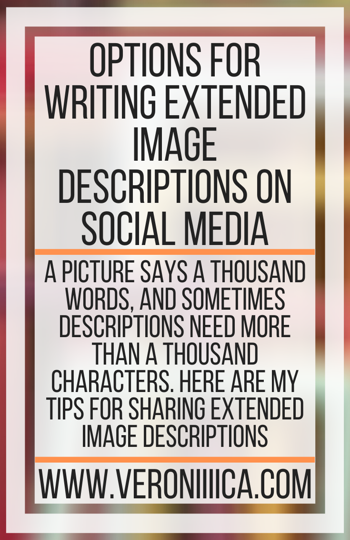

In [6]:
# image = Image.open(requests.get("https://i.stack.imgur.com/pbIdS.png", stream=True).raw)
# image = Image.open(requests.get("https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fcb2bfe0b-96c6-47e4-8fdc-4d98f7cf4f79_768x528.png", stream=True).raw)
image = Image.open(requests.get("https://veroniiiica.com/wp-content/uploads/2020/05/Options-For-Writing-Extended-Image-Descriptions-On-Social-Media.png", stream=True).raw)
image = image.resize((350,540))
image.save('sample.png')
image

In [8]:
custom_config = r'-l eng --oem 3 --psm 6'
# text = pytesseract.image_to_string(image, config=custom_config)
text = pytesseract.image_to_string(image, config = custom_config)
print(text)

__[ EE
OPTIONS FOR
| WRITING EXTENDED
| IMAGE ||
DESCRIPTIONS ON
SOCIAL MEDIA |
A PICTURE SAYS A THOUSAND
| | WORDS, AND SOMETIMES
DESCRIPTIONS NEED MORE i
THAN A THOUSAND
CHARACTERS. HERE ARE MY
| fj TIPS FOR SHARING EXTENDED
IMAGE DESCRIPTIONS
|



In [9]:
try:
  text = pytesseract.image_to_string(image, lang="eng")
  characters_to_remove = string.punctuation
  new_string = text
  for character in characters_to_remove:
    new_string = new_string.replace(character,"")
  print(new_string)
except IOError as e:
  print("Error (%s)" % e)

——
OPTIONS FOR
 WRITING EXTENDED
IMAGE

 DESCRIPTIONS ON
SOCIAL MEDIA

APICTURE SAYS A THOUSAND
WORDS AND SOMETIMES
DESCRIPTIONS NEED MORE
Pre  eer

IMAGE DESCRIPTIONS
WWWVERONIICACOM

 TPS FOR SHARING am



In [10]:
#Extract text from complex images
image = cv2.imread('sample.png')

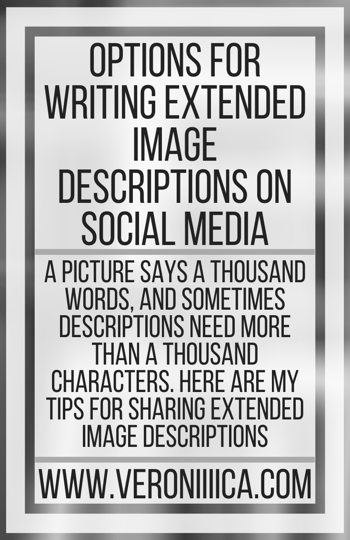

In [11]:
#get grayscale image
def get_grayscale(image):
  return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = get_grayscale(image)
Image.fromarray(gray)

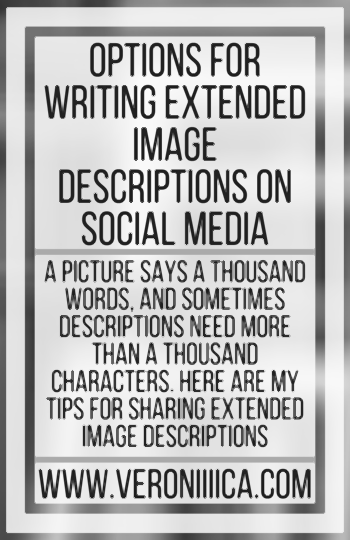

In [12]:
#remove noise
def remove_noise(image):
  return cv2.medianBlur(image,3)
noise = remove_noise(gray)
Image.fromarray(noise)

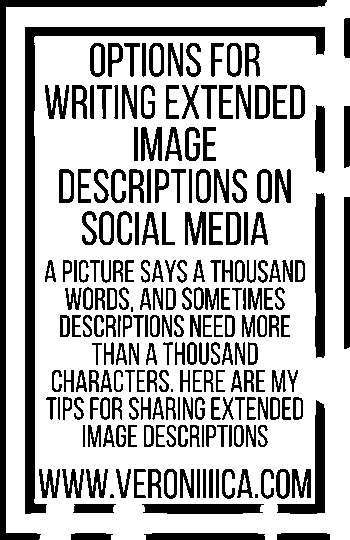

In [13]:
#threshold transformation
def thresholding_image(image):
  return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
threshold = thresholding_image(gray)
Image.fromarray(threshold)

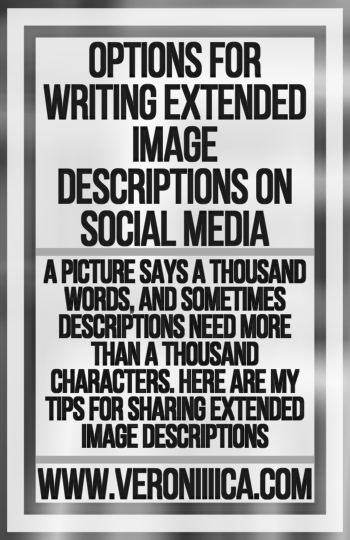

In [14]:
#erosion
def erode(image):
  kernel=np.ones((3,3), np.uint8)
  return cv2.erode(image, kernel, iterations=1)
erode = erode(gray)
Image.fromarray(erode)

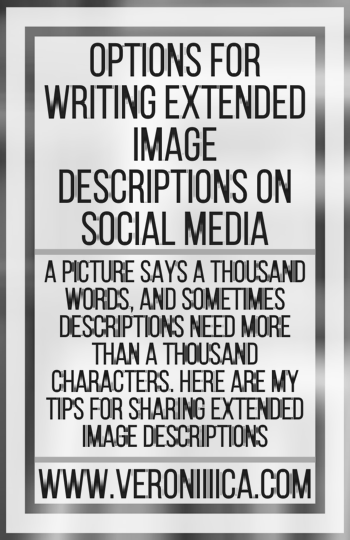

In [15]:
#morphology
def opening(image):
  kernel = np.ones((3,3), np.uint8)
  return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
open = opening(gray)
Image.fromarray(open)

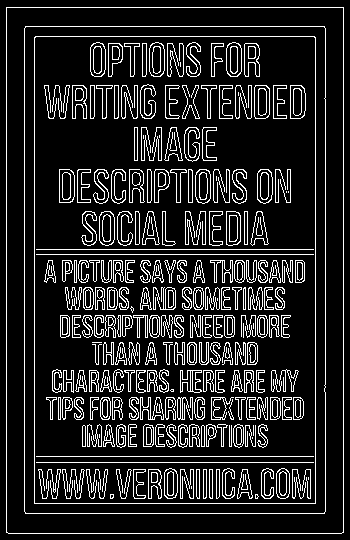

In [16]:
#canny edge detection
def canny(image):
  return cv2.Canny(image, 50, 100)
canny = canny(gray)
Image.fromarray(canny)

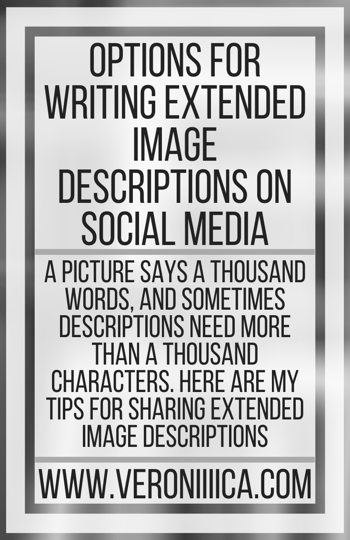

In [17]:
#skew correction
def deskew(image):
  coords = np.column_stack(np.where(image>0))
  angle = cv2.minAreaRect(coords)[-1]
  if angle < -45:
    angle = -(90 + angle)
  else:
    # angle = -angle
    angle = angle - 90
  (h,w) = image.shape[:2]
  center = (w//2, h//2)
  M = cv2.getRotationMatrix2D(center, angle, 1.0)
  rotated = cv2.warpAffine(image, M, (w,h), flags = cv2.INTER_CUBIC, borderMode = cv2.BORDER_REPLICATE)
  return rotated

rotated = deskew(gray)
Image.fromarray(rotated)

In [18]:
#template matching
def match_template(image, template):
  return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)
match = match_template(gray, threshold)
match

array([[0.92585]], dtype=float32)

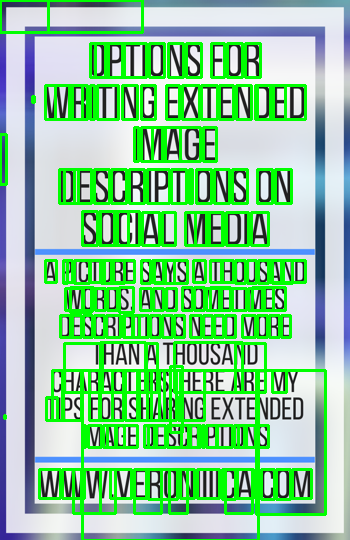

In [19]:
#Draw rectangles around text
img = cv2.imread('sample.png')
h, w, c = img.shape
boxes = pytesseract.image_to_boxes(img)

for b in boxes.splitlines():
  b = b.split(' ')
  img = cv2.rectangle(img, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0,255,0),2)
Image.fromarray(img)

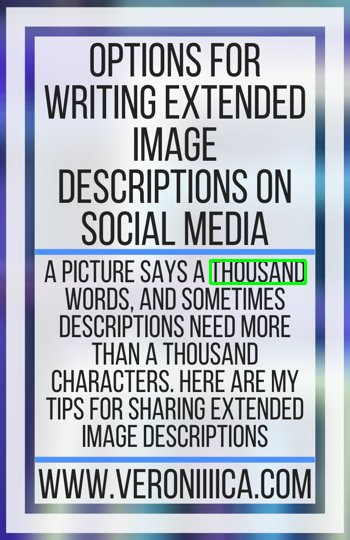

In [20]:
#Drawing rectangles around a specific word
img = cv2.imread('sample.png')
d = pytesseract.image_to_data(img, output_type = Output.DICT)
keys = list(d.keys())

data_pattern = 'THOUSAND'

n_boxes = len(d['text'])
for i in range(n_boxes):
  if int(d['conf'][i] > 60):
    if re.match(data_pattern, d['text'][i]):
      (x,y,w,h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
      img = cv2.rectangle(img, (x,y), (x+w, y+h), (0,255,0), 2)
Image.fromarray(img)